# Historical and future simulation of hailstorms in Australia

In [1]:
%cd ~/git/hist_future_hail/

/home/561/tr2908/git/hist_future_hail


In [2]:
import xarray
import numpy as np
import matplotlib.pyplot as plt
import modules.hist_fut_hail as hf
from dask.distributed import Client

## Settings

In [3]:
base_dir = '/g/data/up6/tr2908/hist_future_hail/'  # Data base directory.
hist_years = np.arange(1989, 2009)  # Historical years.
fut_years = np.arange(2080, 2100)  # Future years.
sims_dir = f'{base_dir}/WRF_v4.4/simulations/cities/'  # Simulation directory.
data_dir = f'{base_dir}/xu_data'  # Xu et al. data directory.
plt.show()  # Start the plotting engine.
plt.rcParams['font.size'] = 12  # Font size for plots.
plt.rcParams['axes.formatter.useoffset'] = False  # Don't use offsets in plots.

In [4]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 7
Total threads: 28,Total memory: 125.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43355,Workers: 7
Dashboard: http://127.0.0.1:8787/status,Total threads: 28
Started: Just now,Total memory: 125.18 GiB
Comm: tcp://127.0.0.1:32837,Total threads: 4
Dashboard: http://127.0.0.1:43827/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:39039,


## Environment

In [5]:
!module list

Currently Loaded Modulefiles:
 1) R/4.3.1   2) pbs  
>

In [6]:
!python --version

Python 3.10.13


## Temperature increases by year

We use a temperature-based framework to talk about future changes. To get mean near-surface air temperature we use the weighted mean (weighted by cosine of latitude) in the Xu et al SSP2-4.5 dataset. The following code can be used to generate this dataset after the lnd file for ssp245 has been wget and unzipped into /scratch.

In [7]:
mean_temps = hf.mean_temp_per_year(infiles={'SSP2-4.5': '/scratch/w42/tr2908/xu_data/lnd.ssp245.*.nc',
                                            'SSP5-8.5': '/scratch/w42/tr2908/xu_data/lnd.ssp585.*.nc'},
                                   outfile=f'{data_dir}/mean_temperature_by_year.nc')

The reference temperature of 13.6 C is the mean temperature 1850-1900, annual using [CMIP6 35-model ensemble](https://interactive-atlas.ipcc.ch/permalink/Gzfztqvg).

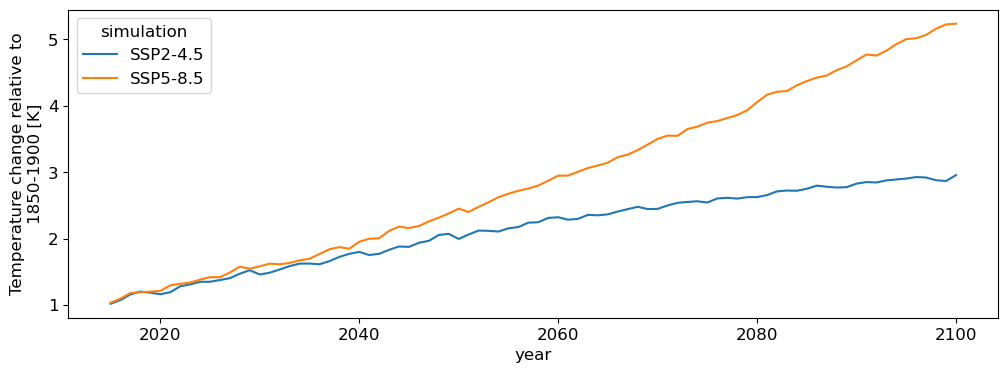

In [8]:
reference_temp = (
    13.6 + 273.15
)  # Mean temperature 1850-1990 using CMIP6 ensemble, annual, 35 models (https://interactive-atlas.ipcc.ch/regional-information#eyJ0eXBlIjoiQVRMQVMiLCJjb21tb25zIjp7ImxhdCI6MTc0MTAxMCwibG5nIjotNTU4MzgyNSwiem9vbSI6MywicHJvaiI6IkVQU0c6NTQwMzAiLCJtb2RlIjoiY29tcGxldGVfYXRsYXMifSwicHJpbWFyeSI6eyJzY2VuYXJpbyI6Imhpc3RvcmljYWwiLCJwZXJpb2QiOiJwcmVJbmR1c3RyaWFsIiwic2Vhc29uIjoieWVhciIsImRhdGFzZXQiOiJIQ01JUDYiLCJ2YXJpYWJsZSI6InRhcyIsInZhbHVlVHlwZSI6IlZBTFVFIiwiaGF0Y2hpbmciOiJTSU1QTEUiLCJyZWdpb25TZXQiOiJhcjYiLCJiYXNlbGluZSI6InByZUluZHVzdHJpYWwiLCJyZWdpb25zU2VsZWN0ZWQiOls0NywxLDMsNCw1LDIsMCw1MCw4LDcsNiw0NiwyOCwxNiwxNywxOCwxOSwzMiwyOSwzMCwzNCwzMywzNSwzMSwyMCwyMSwzNiwyMiw1MSwxMSwxMCw5LDQ4LDQ5LDEzLDE0LDI1LDI2LDI0LDUzLDM3LDU0LDM4LDM5LDQwLDQxLDQyLDU3LDEyLDUyLDIzLDU1LDI3LDU2LDQzLDE1LDQ1LDQ0XX0sInBsb3QiOnsiYWN0aXZlVGFiIjoidGFibGUiLCJzaG93aW5nIjp0cnVlLCJtYXNrIjoibm9uZSIsInNjYXR0ZXJZTWFnIjoiVkFMVUUiLCJzY2F0dGVyWVZhciI6InRhcyJ9fQ==)
mean_temps['change'] = mean_temps.tas - reference_temp
mean_temps.change.attrs = {'long_name': 'Temperature change relative to 1850-1900', 'units': 'K'}
mean_temps.change.plot(figsize=(12, 4), hue='simulation')
plt.show()

In [9]:
mean_temps = mean_temps.sel(simulation='SSP2-4.5')
cross_2 = mean_temps.where(mean_temps.change > 2, drop=True).year.min().values
cross_25 = mean_temps.where(mean_temps.change > 2.5, drop=True).year.min().values
mean_change_fut_years = (
    mean_temps.sel(year=slice(fut_years.min(), fut_years.max() + 1)).change.mean().values
)
print(
    f'Mean temperature change over the future years selected here ({fut_years.min()}-{fut_years.max()+1}) is {np.round(mean_change_fut_years, 2)} K over pre-industrial.'
)
print(
    f'Mean temperature crosses 2 degrees over pre-industrial in {cross_2} (window is {cross_2-10}-{cross_2+10}).'
)
print(
    f'Mean temperature crosses 2.5 degrees over pre-industrial in {cross_25} (window is {cross_25-10}-{cross_25+10}).'
)

Mean temperature change over the future years selected here (2080-2100) is 2.81 K over pre-industrial.
Mean temperature crosses 2 degrees over pre-industrial in 2048 (window is 2038-2058).
Mean temperature crosses 2.5 degrees over pre-industrial in 2071 (window is 2061-2081).


Max factor is 1.07 in domain 8.
Min factor is 1.0 in domain 3.


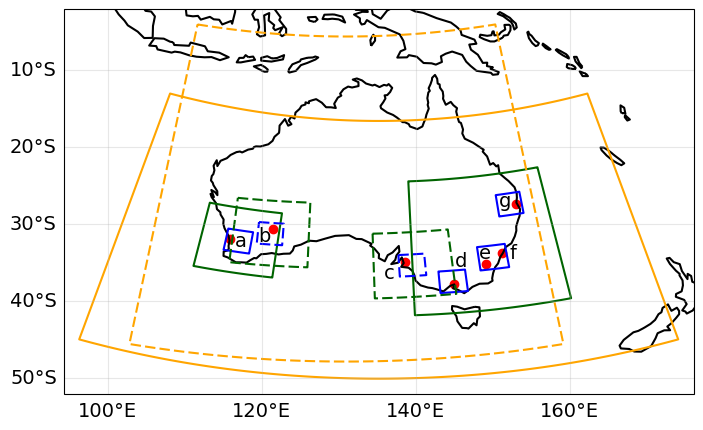

In [10]:

hf.plot_wrf_domains(wps_files = {f'{base_dir}/WRF_v4.4/simulations/cities/ssp245/2080-2081/WPS/geo_em.d01.nc': ('solid', 'orange'),
                                 f'{base_dir}/WRF_v4.4/simulations/cities/ssp245/2080-2081/WPS/geo_em.d02.nc': ('solid', 'darkgreen'),
                                 f'{base_dir}/WRF_v4.4/simulations/cities/ssp245/2080-2081/WPS/geo_em.d03.nc': ('solid', 'blue'),
                                 f'{base_dir}/WRF_v4.4/simulations/cities/ssp245/2080-2081/WPS/geo_em.d04.nc': ('solid', 'darkgreen'),
                                 f'{base_dir}/WRF_v4.4/simulations/cities/ssp245/2080-2081/WPS/geo_em.d05.nc': ('solid', 'blue'),
                                 f'{base_dir}/WRF_v4.4/simulations/cities/ssp245/2080-2081/WPS/geo_em.d06.nc': ('solid', 'blue'),
                                 f'{base_dir}/WRF_v4.4/simulations/cities/ssp245/2080-2081/WPS/geo_em.d07.nc': ('solid', 'blue'),
                                 f'{base_dir}/WRF_v4.4/simulations/remote/ssp245/2080-2081/WPS/geo_em.d01.nc': ((0, (5, 2)), 'orange'),
                                 f'{base_dir}/WRF_v4.4/simulations/remote/ssp245/2080-2081/WPS/geo_em.d02.nc': ((0, (5, 2)), 'darkgreen'),
                                 f'{base_dir}/WRF_v4.4/simulations/remote/ssp245/2080-2081/WPS/geo_em.d03.nc': ((0, (5, 2)), 'blue'),
                                 f'{base_dir}/WRF_v4.4/simulations/remote/ssp245/2080-2081/WPS/geo_em.d04.nc': ((0, (5, 2)), 'darkgreen'),
                                 f'{base_dir}/WRF_v4.4/simulations/remote/ssp245/2080-2081/WPS/geo_em.d05.nc': ((0, (5, 2)), 'blue')},
                    pts=hf.cities, figsize=(12,5),
                    labels={'Perth': ('a', (8, -5)),
                            'Kalgoorlie': ('b', (-6, -8)),
                            'Adelaide': ('c', (-11, -12)),
                            'Melbourne': ('d', (5, 13)),
                            'Canberra': ('e', (-0.5, 4.5)),
                            'Sydney': ('f', (8, -3)),
                            'Brisbane': ('g', (-8, -1))},
                    file='paper/figures/domains.pdf')

## Changes by city

Rerun to get percentages of removed hail... 

Processing d03...
Processing d05...
Processing d06...
Processing d07...


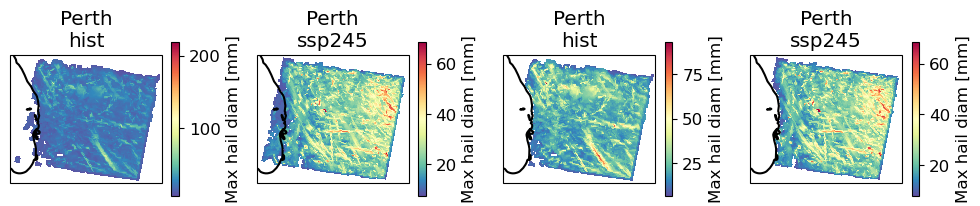

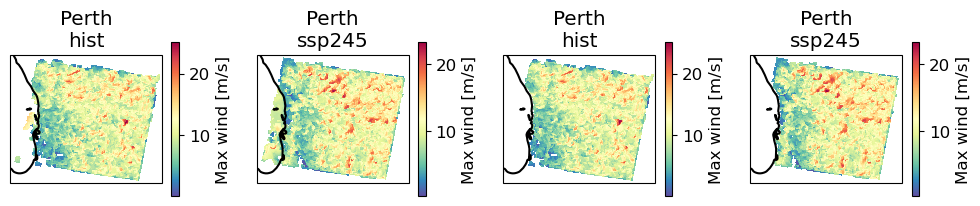

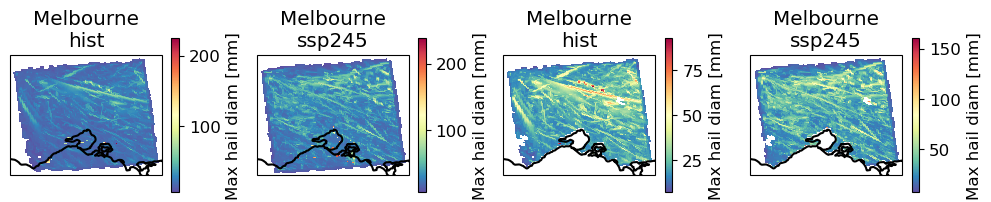

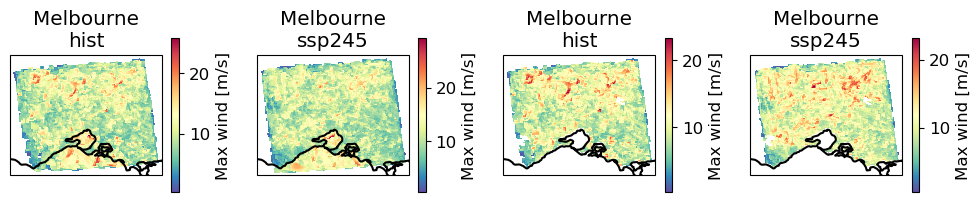

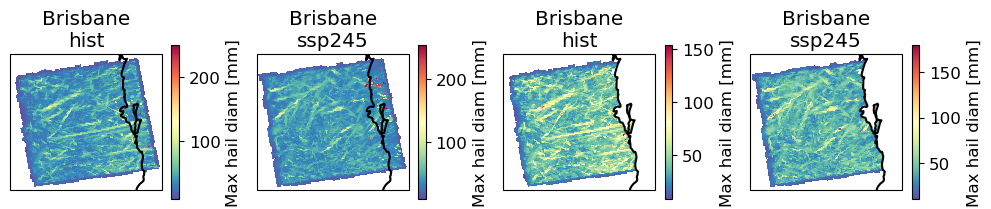

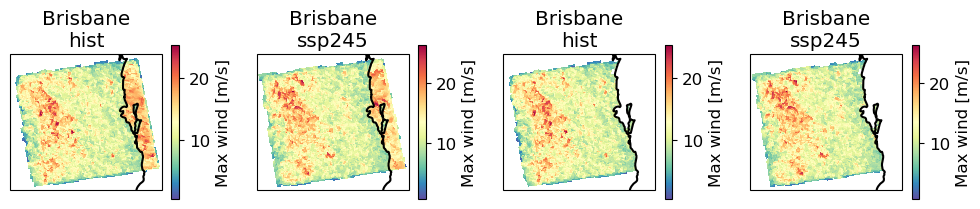

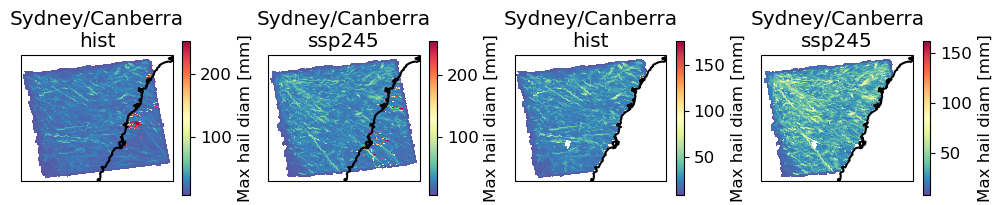

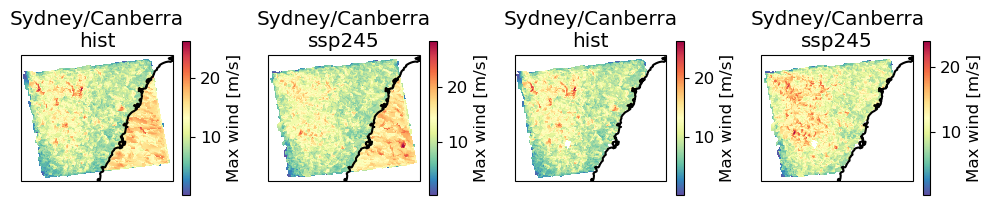

In [11]:
maxima_cities = hf.process_maxima(sim_dir='/g/data/up6/tr2908/hist_future_hail/WRF_v4.4/simulations/cities/')

Processing d03...
Processing d05...


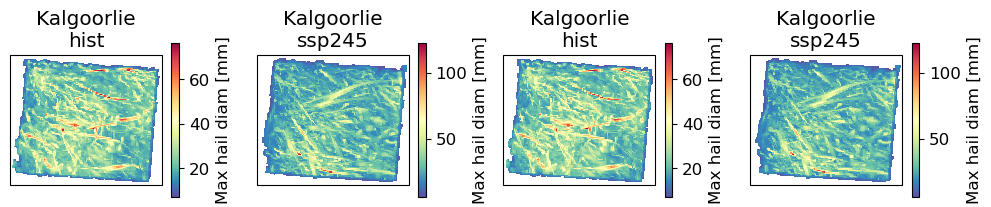

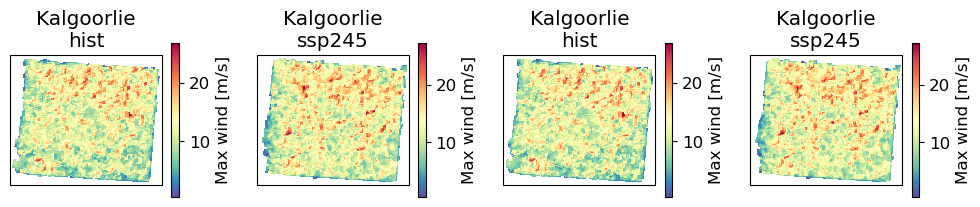

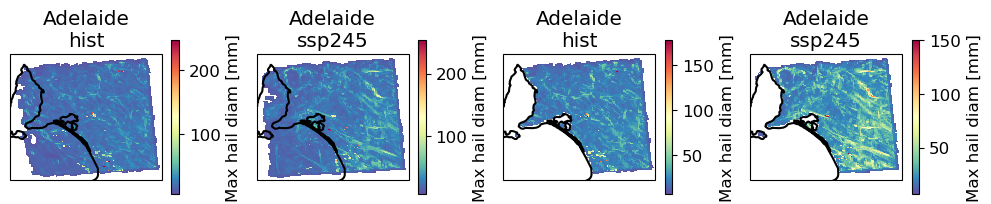

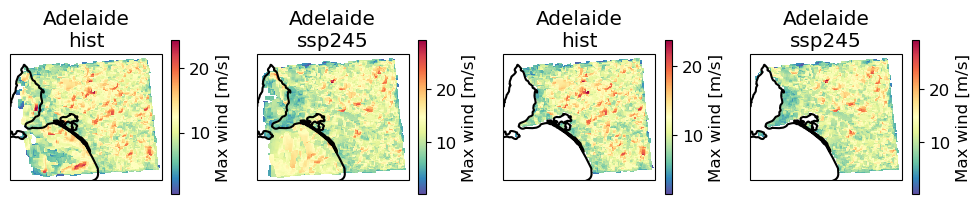

In [12]:
maxima_remote = hf.process_maxima(sim_dir='/g/data/up6/tr2908/hist_future_hail/WRF_v4.4/simulations/remote/',
                                  domains={'Kalgoorlie': 3, 'Adelaide': 5},
                                  time_adjust={'Kalgoorlie': 8, 'Adelaide': 10},
                                  results_dir='/g/data/up6/tr2908/hist_future_hail/results/',
                                  variables=['hailcast_diam_max', 'wind_10m'],
                                  time_adjust_mins={'Kalgoorlie': 0, 'Adelaide': 30},
                                  file_dir='paper/figures/')

In [88]:
maxima = xarray.merge([maxima_cities, maxima_remote])

In [97]:
hf.plot_maxima(maxima=maxima, variable='hailcast_diam_max', scale_label = 'Maximum hail size [mm]', file = 'paper/figures/max_hail_sizes_by_domain.pdf')

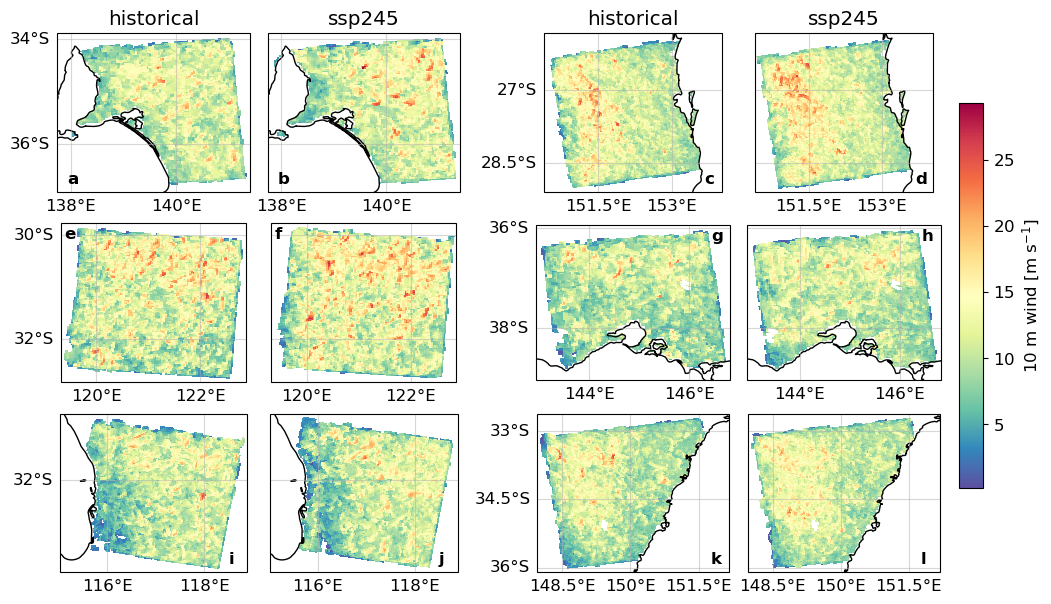

In [96]:
hf.plot_maxima(maxima=maxima, variable='wind_10m', scale_label = '10 m wind [m s$^{-1}$]', file = 'paper/figures/max_10m_winds_by_domain.pdf')

In [ ]:
# def plot_dist_comparison(dat, variables, varnames, maskvar=None, mask=None, quantiles=None,
#                          figsize=(12,6), xlims=None, log=None, file=None, invert=False,
#                          palettes=None, hspace=0.7, wspace=0.5, showfliers=False):
#     """
#     Plot a distribution comparison between simulations.

#     Arguments:
#         dat: Data to use for the plots.
#         variables: The variables to plot for (one row per variable).
#         quantiles: If required, the quantile to select.
#         varnames: Pretty-print name of variables for axis labels.
#         figsize: Figure width, height.
#         xlims: Limit x axis extent?
#         log: X axis in log scale?
#         invert: Invert the plot row/columns?
#         palettes: Palette for each variable?
#         hspace, wspace: grid spec spacings.
#         showfliers: Show outliers in plots?
#     """

#     fig, axs = plt.subplots(ncols=len(dat.city.values), nrows=len(variables), figsize=figsize, gridspec_kw={'hspace': hspace,
#                                                                                                             'wspace': wspace})

#     for v, var in enumerate(variables):
#         for i, city in enumerate(dat.city.values):

#             ax = axs[v, i]
#             if invert:
#                 ax = axs[i, v]

#             if quantiles[v] is not None:
#                 d = dat.sel(city=city, quantile=quantiles[v])[variables[v]]
#             else:
#                 d = dat.sel(city=city)[variables[v]]
#                 assert not 'quantile' in d.dims, 'Quantile needs to be specified for this variable.'

#             hist = d.sel(sim='Historical').values
#             fut = d.sel(sim='+2.8 C').values
#             ttest_res, pval = scs.ttest_ind(hist[~np.isnan(hist)],
#                                             fut[~np.isnan(fut)], equal_var=False)
#             sig = pval < 0.05
#             print(f'{city} {var} - sig diff? {sig}')

#             if maskvar is not None:
#                 if mask[v] == True:
#                     m = dat.sel(city=city)[maskvar]
#                     d = d.where(m > 0)

#             palette = None
#             if palettes is not None:
#                 palette = palettes[v]

#             sns.boxplot(data=d.to_dataframe(), x=variables[v], hue='sim', fill='sim',
#                         y='sim', ax=ax, showfliers=showfliers, palette=palette, showmeans=True,
#                         meanprops={'marker': 'o',
#                                    'markerfacecolor': 'white',
#                                    'markeredgecolor': 'black',
#                                    'markersize': 10})

#             if v == 0 or invert:
#                 ax.set_title(city)

#             if (not invert) or (i == len(dat.city.values)-1):
#                 ax.set_xlabel(varnames[v])
#             else:
#                 ax.set_xlabel('')

#             if not xlims is None:
#                 ax.set_xlim(xlims[v])

#             if not log is None:
#                 if log[v]:
#                     ax.set_xscale('log')

#             if invert and v != 0:
#                 ax.set_yticks([])

#             ax.set_ylabel('')

#     if not file is None:
#         plt.savefig(fname=file, bbox_inches='tight')
#         plt.show()
#         plt.close()
#     else:
#         plt.show()

In [ ]:
# a = stats.sel(quantile=1, city='Brisbane').mixed_100_cape_quantile.isel(sim=0).dropna('time')
# b = stats.sel(quantile=1, city='Brisbane').mixed_100_cape_quantile.isel(sim=1).dropna('time')

In [ ]:
# plt.rcParams['font.size'] = 14
# plot_dist_comparison(dat=stats,
#                      variables=['hailcast_diam_max_quantile',
#                                 'hail_occurrences'],
#                      varnames=['Median hail size [mm]',
#                                'Annual hail days'],
#                      quantiles=[0.5, None],
#                      log=[False, False],
#                      figsize=(20, 3.5),
#                      file='hail_changes.pdf',
#                      palettes=['Reds', 'Blues'],
#                      showfliers=True)

In [ ]:
# plot_dist_comparison(dat=stats, #maskvar='hailcast_diam_max_mean',
#                      variables=['mixed_100_cape_quantile',
#                                 'mixed_100_cin_quantile',
#                                 'shear_magnitude_quantile',
#                                 'melting_level_mean'],
#                      varnames=['Max CAPE [J kg$^{-1}$',
#                                'Min CIN [J kg$^{-1}$',
#                                'Max S06 [m s$^{-1}$]',
#                                'Mean MLH [m]'],
#                      #mask=[True, True, True, True],
#                      quantiles=[1, 0, 1, None],
#                      log=[False, False, False, False],
#                      figsize=(15, 8), invert=True,
#                      palettes=['PuRd', 'Greens', 'Greys', 'Oranges'],
#                      wspace=0.15, showfliers=True,
#                      file='ing_changes.pdf')